## **Problem Statement:**

Evaluate the policy for a card game called Blackjack.

## **Environment**

* Game is played against a fixed dealer.
* Game has a replacement or an infinite deck.
* Moves:
  * Hit = Player asking for additional card
  * Stick = Player stops asking for the additional card
  * Bust = The sum of all cards exceed 21 
* Score of the cards:
  * Each of the cards Jack, Queen, and King have reward of 10
  * Each Ace has a reward of 11 or 1 and is called unstable at '11'
* Goal: Acquire cards that add up to 21 and must not go beyond 21.
* Rules:
  * Game starts with one card faced up and one card faced down for the player and the dealer.
  * Player can ask for additional cards until the sum of the cards exceed 21 or player stops voluntarily.
  * After the player sticks, the dealer shows the facedown card and draws cards from the deck until the sum is 17 or greater.
  * After drawing cards, the player wins if the dealer exceeds the allowed sum of 21 and vice versa.
  * If neither of them busts, the winner is decided by finding whoever has a score near to 21.
* Action:
  * STICK = 0
  * HIT = 1
* Reward:
  * Win = +1
  * Draw = 0
  * Loss = -1
* Observation:
  * Current sum of players
  * Dealer's one showing card
  * Player having a usable ace or not

Environment courtsey: This environment corresponds to the version of the Blackjack problem described in Example 5.1 in Reinforcement Learning: An Introduction by Sutton and Barto (1998) and OpenAI Gym.

## **Import Libraries and Environment**

In [2]:
import matplotlib
import numpy as np
import sys
import collections
from collections import defaultdict
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import gym
env = gym.make("Blackjack-v1")


## **Solution**

**Arguments:**

* policy: Maps an observation to action probabilities
* env: OpenAI gym environment
* num_episodes: Number of episodes
* discount_factor: Gamma discount factor

### **Monte Carlo Prediction**

In [3]:
#Calculating value-function

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V

#### **Define a Policy that Sticks and Hits** 

In [4]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

#### **Episodes**

In [5]:
#Running 10000 episodes
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)

#Running 50000 episodes
V_50k = mc_prediction(sample_policy, env, num_episodes=50000)

### **Creat Plot Function**

In [6]:
def plot_value_function(V, title="Value Function"):
    
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

#### **Plot the Prediction**

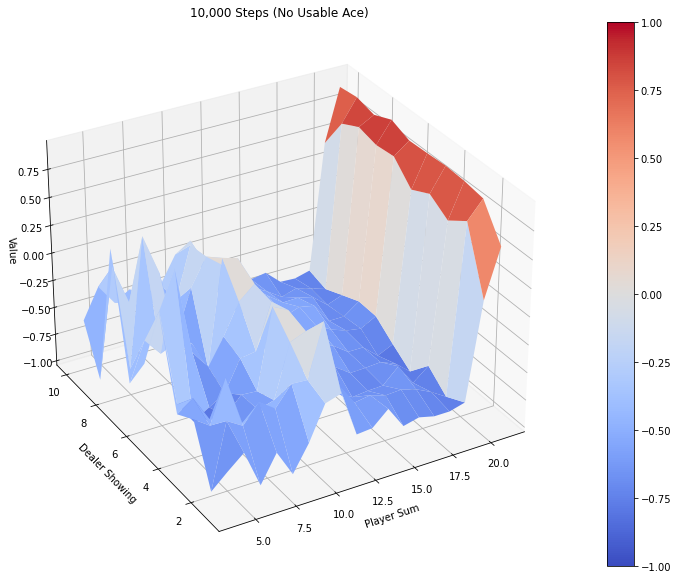

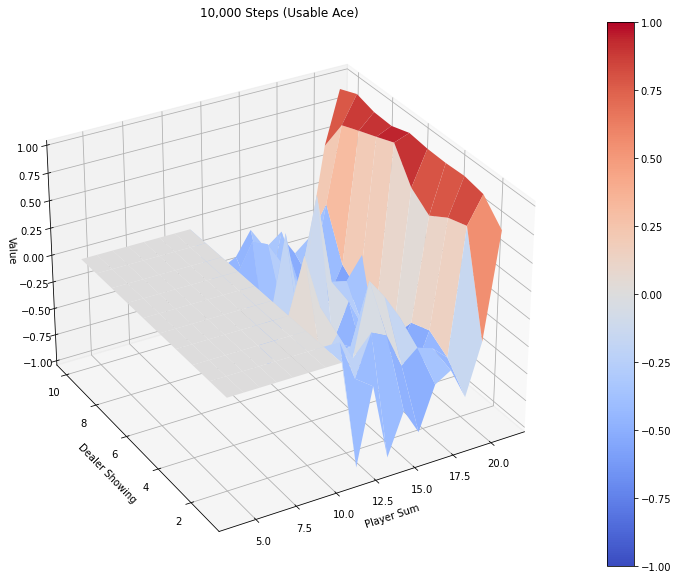

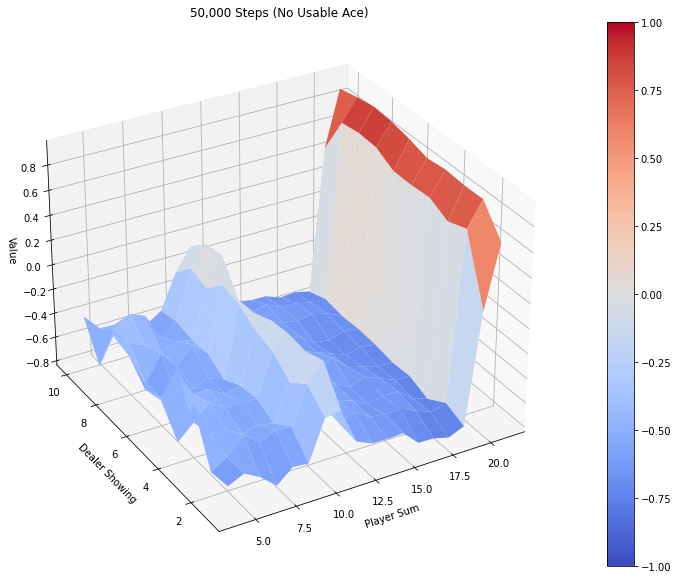

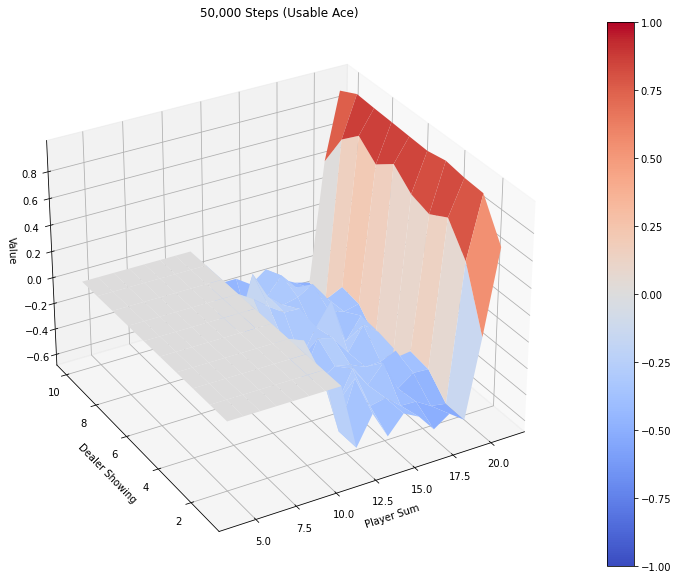

In [7]:
#Plotting 10k episodes
plot_value_function(V_10k, title="10,000 Steps")

#Plotting 50k episodes
plot_value_function(V_50k, title="50,000 Steps")